# Import

In [273]:
import os
import numpy as np

from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import lightkurve as lk
from astroquery.simbad import Simbad
import pandas as pd 
from numpy import genfromtxt
from sklearn.preprocessing import normalize
from labellines import labelLine, labelLines


# #tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



## Check GPU

In [150]:
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Data

In [151]:
pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v4/0.csv',delimiter=',').to_numpy().shape

(122, 241)

In [21]:
all_data = np.empty((1,240))
for dataset in ['Data_v4']:
  new_data = np.empty((1,241))
  for i in range(1610*2):
    try:
      new_data = np.concatenate((new_data,pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/'+dataset+'/'+str(i)+'.csv',delimiter=',').to_numpy()), axis=0)
    except:
      continue
  new_data = new_data[1:].T[1:].T
  print(new_data.shape)
  all_data = np.concatenate((all_data,new_data),axis=0)
all_data = all_data[1:]
print(all_data.shape)
# pd.read_csv('/content/drive/MyDrive/Research - Yihong Song and Rohit Prasanna/Yihong/Data_v2/0.csv',delimiter=',').to_numpy

(214499, 240)
(214499, 240)


In [22]:
print(all_data)
print(all_data.T[1])

[[7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 2.84220046e-01
  1.98787545e-01 3.52143589e-01]
 [7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 9.00410425e-02
  2.38116041e-01 1.33820551e-01]
 [7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 6.99888643e-02
  1.28790969e-01 2.76750793e-01]
 ...
 [1.29345740e+07 4.83400000e+03 2.38700000e+00 ... 2.39368800e-01
  1.34656354e-01 3.30117909e-01]
 [1.29345740e+07 4.83400000e+03 2.38700000e+00 ... 5.32880594e-01
  1.53275869e-01 1.18398710e+00]
 [1.29345740e+07 4.83400000e+03 2.38700000e+00 ... 2.38655505e-01
  4.39093700e-01 9.84966052e-01]]
[4751. 4751. 4751. ... 4834. 4834. 4834.]


In [23]:
def isolate_observations(data):
    kic = 0
    res = np.empty((1,474))
    for i in range(len(data)):
        if(data[i][0]!=kic):
            kic = data[i][0]
            res = np.vstack((res,data[i]))
    return res

# iso_data = isolate_observations(all_data).T[:10].T
# print(iso_data)

In [24]:
def extract_xy(all_data):
    all_x = all_data.T[4:241].T
    all_y = all_data.T[1:4].T
    print(all_x.shape,all_y.shape)
    teff_y = all_y.T[0].T
    print(teff_y.shape)
    print(teff_y)
    print(all_x[0])
    return all_x,teff_y

all_x,teff_y = extract_xy(all_data)

(214499, 236) (214499, 3)
(214499,)
[4751. 4751. 4751. ... 4834. 4834. 4834.]
[ 0.         13.16467881 11.85662574  5.37137053  2.34753016  7.56242166
  7.09166395  8.9345866   4.47222976  5.44573758  7.99705157  6.5553589
  7.43230342  2.14978082  6.70502292  2.11453161  1.47941903  3.4679212
  0.95694623  6.41945024 13.71684545  2.6618294   6.7777871   4.03523607
  1.65132679  1.22634052  2.47702523  1.62667739  2.94700681  2.16647403
  0.86192238  1.94095918  1.36412959  1.50011758  1.52687553  0.3987771
  0.26511563  1.70271956  2.16544294  1.24192005  0.74680304  1.26339405
  2.43964765  0.62723454  1.35998087  0.3313366   0.39359298  0.8410012
  0.59152181  0.47106868  1.50347768  1.05735322  0.37600592  1.01079496
  0.06908752  1.03337513  0.57106625  0.72521993  0.70155079  0.43960006
  1.06916899  1.62702797  0.75722071  0.81743033  0.08991218  0.78076904
  0.58342839  0.82547409  1.41460742  0.44502772  0.51703072  0.16467888
  0.85940931  0.28964864  0.38246988  0.20737913  

In [25]:
def normalize_with_moments(X_train, axes=0, epsilon=1e-8,keep_dims=True):
    x = tf.convert_to_tensor(X_train)
    mean, variance = tf.nn.moments(x, axes=axes)
    x_normed = (x - mean) / tf.sqrt(variance + epsilon) # epsilon to avoid dividing by zero
    return x_normed

def normalize_x(x):
    x = x.T
    for i in range(len(x)):
        x[i] = x[i] / np.linalg.norm(x[i])
    return x.T

In [26]:
# teff_y = normalize_with_moments(teff_y).numpy()
# all_x = normalize_x(all_x)
# print(teff_y)
# print(all_x)

In [27]:
print(all_x[1])

[ 1.          8.43454255  3.81606884  5.60029841  4.00062612  1.87763442
  6.60502431  1.75453517  2.03889624  2.15967502  6.61839709 10.96603738
  1.00941128 11.83732916  6.832062    2.11275395  0.68517313  2.80103935
  3.12226637  2.10477594  6.60518561  0.61505648  2.00240753  3.97648499
  1.3740333   1.3024308   2.02690753  1.48491184  1.63691857  1.22361546
  2.55480434  1.85227138  0.76009708  0.77010233  0.35528595  1.09636679
  0.89292322  1.34251061  0.63681166  0.43798736  1.08026908  0.28756933
  0.23743421  0.18253782  0.52691456  0.34023662  0.32434848  0.73180473
  0.15601266  0.71085421  0.67786938  0.25223334  0.57520825  0.52608914
  0.17351905  0.61305125  0.5747885   0.35867008  0.50785905  0.28822274
  0.18542083  0.72036011  0.74996212  0.78635087  0.37852229  0.35192467
  0.29241703  0.1940635   0.62021354  0.59715896  0.32950041  0.48906543
  0.57471503  0.23230492  0.60162748  0.24766141  0.32702928  0.24256991
  0.30468094  0.40705864  0.32715655  0.47648729  0

# Machine Learning

In [28]:
train_x,test_x,train_y,test_y=train_test_split(all_x, teff_y, test_size=0.20, random_state=42)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)
train_x = np.asarray(train_x).astype('float32')
test_x = np.asarray(test_x).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

(171599, 236) (42900, 236) (171599,) (42900,)
(171599, 236) (42900, 236) (171599,) (42900,)


In [15]:
tf.test.gpu_device_name() # No GPU Sad :v
# tf.config.optimizer.set_jit(True)
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()
model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))

#model.add(layers.Embedding(input_dim=64, output_dim=16))
#model.add(layers.LSTM(128,dr
# opout=0.2,recurrent_dropout=0.2,input_dim=(train_x.shape[2])))
#model.add(layers.Conv1D(1024,1,activation='relu',input_shape=(train_x.shape)))
#model.add(layers.Conv1D(256,1,activation='relu'))
model.add(layers.Dense(2048, activation="relu", input_shape=((236,))))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(4, activation="relu"))
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              485376    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 2

2022-01-13 21:22:11.565751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-13 21:22:11.565774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)
monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, 
        patience=50, verbose=1, mode='auto',
        restore_best_weights=True)

# def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('loss') <= 15000):
#         print("\n\n\nReached 0.05 loss value so cancelling training!\n\n\n")
#         model.stop_training = True


# trainingStopCallback = on_epoch_end()


In [17]:
history = model.fit(train_x, train_y, epochs=1000,validation_data=(test_x, test_y),callbacks=[monitor], verbose=2)
# history = model.fit(train_x, train_y, epochs=150,validation_data=(test_x, test_y), verbose=2)

2022-01-13 21:22:14.219448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-13 21:22:14.219747: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-13 21:22:14.388883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/1000


2022-01-13 21:24:19.677570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16124/16124 - 141s - loss: 284853.0938 - accuracy: 0.0000e+00 - val_loss: 541402.9375 - val_accuracy: 0.0000e+00
Epoch 2/1000
16124/16124 - 139s - loss: 79069.0547 - accuracy: 0.0000e+00 - val_loss: 101733.6172 - val_accuracy: 0.0000e+00
Epoch 3/1000
16124/16124 - 143s - loss: 59741.8086 - accuracy: 0.0000e+00 - val_loss: 48637.1250 - val_accuracy: 0.0000e+00
Epoch 4/1000
16124/16124 - 143s - loss: 45550.4727 - accuracy: 0.0000e+00 - val_loss: 34786.1172 - val_accuracy: 0.0000e+00
Epoch 5/1000
16124/16124 - 146s - loss: 36425.1211 - accuracy: 0.0000e+00 - val_loss: 35605.1250 - val_accuracy: 0.0000e+00
Epoch 6/1000
16124/16124 - 142s - loss: 35604.1172 - accuracy: 0.0000e+00 - val_loss: 33617.6602 - val_accuracy: 0.0000e+00
Epoch 7/1000
16124/16124 - 140s - loss: 35175.9023 - accuracy: 0.0000e+00 - val_loss: 33282.0547 - val_accuracy: 0.0000e+00
Epoch 8/1000
16124/16124 - 141s - loss: 35137.1523 - accuracy: 0.0000e+00 - val_loss: 35011.3555 - val_accuracy: 0.0000e+00
Epoch 9/1000
16124

In [18]:
model.save('/Users/michaelsong/Documents/GitHub/starzam/Models/m5.9')

2022-01-14 01:35:13.349609: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/michaelsong/Documents/GitHub/starzam/Models/m5.9/assets


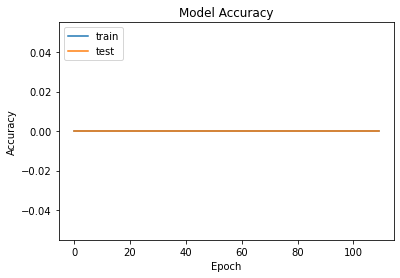

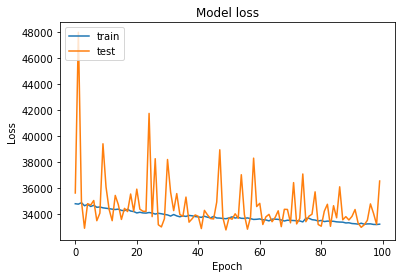

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/5.9_training.png')
plt.show()

In [152]:
model = tf.keras.models.load_model('/Users/michaelsong/Documents/GitHub/starzam/Models/m5.7')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              485376    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 3,239,937
Trainable params: 3,239,937
Non-trainable params: 0
_________________________________________________________________


In [159]:
plot_model(model,to_file='/Users/michaelsong/Documents/GitHub/starzam/Results/5.7_model',show_shapes=True)
plot_model(
    model,
    to_file='/Users/michaelsong/Documents/GitHub/starzam/Results/5.7_model',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [29]:
rand_data = np.empty((1,241))
for i in range(1610):
  try:
    rand_data = np.concatenate((rand_data,pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v5/'+str(i)+'.csv',delimiter=',').to_numpy()), axis=0)
  except:
    continue
rand_data = rand_data[1:].T[1:].T
print(rand_data.shape)
# pd.read_csv('/content/drive/MyDrive/Research - Yihong Song and Rohit Prasanna/Yihong/Data_v2/0.csv',delimiter=',').to_numpy

(215222, 240)


In [30]:
rand_x,rand_y = extract_xy(rand_data)
# rand_x = train_x[214499:]
# rand_y = train_y[214499:]
# train_x = train_x[:214499]
# train_y = train_y[:214499]

(215222, 236) (215222, 3)
(215222,)
[4751. 4751. 4751. ... 4834. 4834. 4834.]
[ 0.         14.90008455 15.50298007  5.21597451  0.90830632  6.20644851
  7.57179809 11.6459395   4.23234164  5.94067695  6.52288898  8.24150251
  8.24082509  3.0395033   6.79973021  4.53366015  0.3684131   3.1691568
  1.80376791  5.53454395 14.8961291   2.74725918  7.71266579  4.99388222
  2.06427727  1.78502294  2.54900389  1.96493493  2.57559828  1.92052474
  0.80277816  1.99947775  1.35893309  1.67625249  1.17480514  0.25672505
  0.31081051  1.21989282  1.70213929  1.20731647  0.93159443  0.81903248
  2.22338649  0.69065388  1.11967885  0.22592404  0.31651415  0.71181726
  0.17388933  0.66229278  1.18461127  1.10461002  0.83177554  1.0551641
  0.48302564  1.57553744  0.17964806  0.794371    0.86703197  0.45893159
  1.34795274  1.30622146  0.83207013  0.63664459  0.30800708  0.87276054
  0.45499416  0.83302011  1.15396698  0.35490575  0.63358948  0.33101004
  0.76273555  0.2994764   0.32217782  0.10424394

In [79]:
pred_test_y = model.predict(test_x).reshape(-1)
pred_train_y = model.predict(train_x).reshape(-1)
pred_rand_y = model.predict(rand_x).reshape(-1)
print(pred_test_y.shape,pred_train_y.shape)
print(pred_train_y)
print(train_y)

2022-01-18 11:17:56.036911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(42900,) (171599,)
[4906.694  5125.9756 4901.121  ... 5018.1743 5028.9873 4930.308 ]
[5116. 5013. 4996. ... 5145. 4924. 4820.]


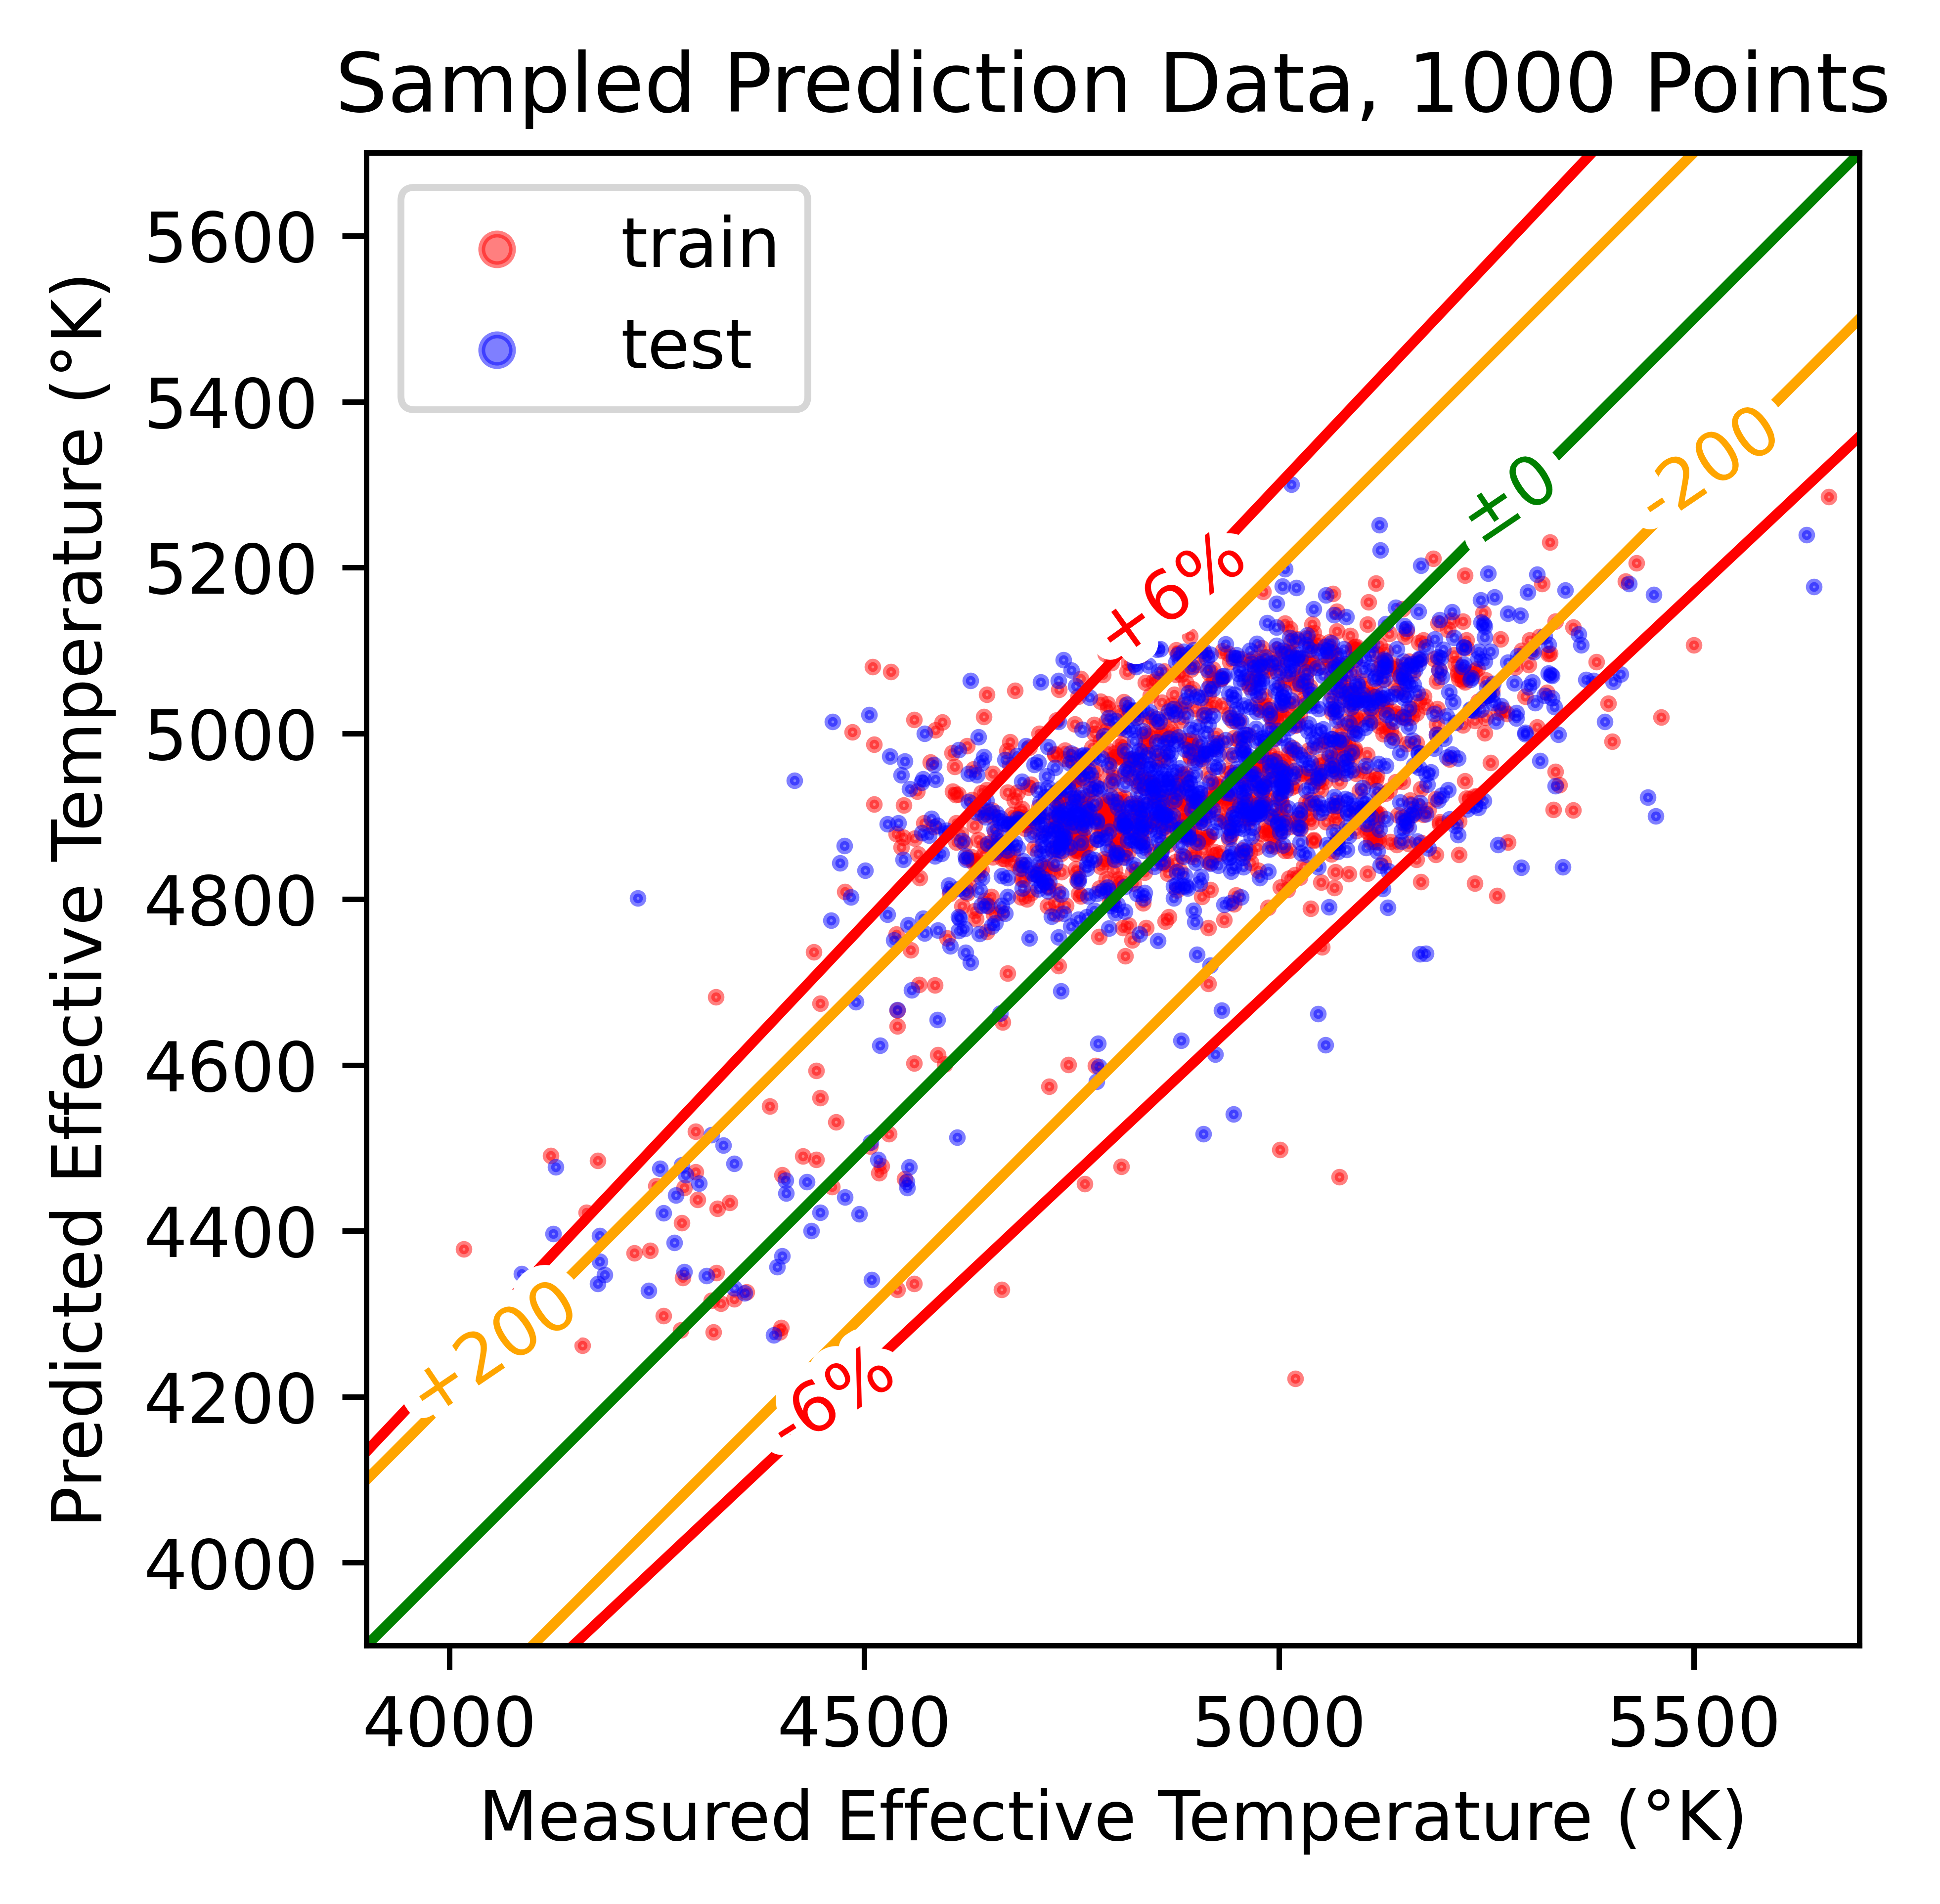

In [318]:
plt.rcParams['figure.dpi'] = 1000
plt.scatter(train_y[:1000],pred_train_y[:1000], c='red', alpha=0.5,s=2)
plt.scatter(test_y[:1000],pred_test_y[:1000], c='blue', alpha=0.5,s=2)
# plt.hist2d(train_y,pred_train_y,bins=[100,100],cmin=20)
# plt.hist2d(test_y,pred_test_y,bins=[100,100],cmin=20,cmap=plt.cm.BuPu)


# plt.scatter(rand_y,pred_rand_y, c='orange', alpha=0.5,s=0.1)

bot = 3900
top = 5700

linex = np.linspace(bot, top)
liney = linex
lineytop = linex*1.06
lineybot = linex*0.94
lineytop2 = linex+200
lineybot2 = linex-200
# Create the plot
plt.plot(linex, liney,c="green",label="±0")
plt.plot(linex, lineytop,c="red",label="+6%")
plt.plot(linex, lineybot,c="red",label="-6%")
plt.plot(linex, lineytop2,c="orange",label="+200")
plt.plot(linex, lineybot2,c="orange",label="-200")
labelLines(plt.gca().get_lines(), zorder=2.5)


plt.xlim(bot, top)
plt.ylim(bot, top)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Sampled Prediction Data, 1000 Points')
plt.ylabel('Predicted Effective Temperature (°K)')
plt.xlabel('Measured Effective Temperature (°K)')
lgnd = plt.legend(['train', 'test'], loc='upper left')
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/s1.png')
plt.show()


In [161]:
def normalize1D(data):
    return np.divide(np.nan_to_num(data,np.nanmean(data)),np.nanmax(data))

In [309]:
mse = mean_squared_error(normalize1D(test_y),normalize1D(pred_test_y),squared=False)
mae = mean_absolute_error(normalize1D(test_y),normalize1D(pred_test_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.07766641 0.07262673


In [310]:
mse = mean_squared_error(test_y,pred_test_y,squared=False)
mae = mean_absolute_error(test_y,pred_test_y)
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
173.87868 135.48291


In [299]:
mse = mean_squared_error(normalize1D(train_y),normalize1D(pred_train_y),squared=False)
mae = mean_absolute_error(normalize1D(train_y),normalize1D(pred_train_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.06798132 0.06272318


In [305]:
mse = mean_squared_error(train_y,pred_train_y,squared=False)
mae = mean_absolute_error(train_y,pred_train_y)
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
174.05443 135.63599


In [306]:
mse = mean_squared_error(normalize1D(rand_y),normalize1D(pred_rand_y),squared=False)
mae = mean_absolute_error(normalize1D(rand_y),normalize1D(pred_rand_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.04377198936243973 0.03681477084403253


In [307]:
mse = mean_squared_error(rand_y,pred_rand_y,squared=False)
mae = mean_absolute_error(rand_y,pred_rand_y)
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
177.88879048752096 137.85608371389665


In [304]:
errormargin = 0.03
test_count = 0
for i in range(len(normalize1D(test_y))):
    if test_y[i]*(1-errormargin) <= pred_train_y[i] <= test_y[i]*(1+errormargin):
        test_count+= 1
train_count = 0
for i in range(len(normalize1D(train_y))):
    if train_y[i]*(1-errormargin) <= pred_train_y[i] <= train_y[i]*(1+errormargin):
        train_count+= 1
rand_count = 0
for i in range(len(normalize1D(rand_y))):
    if rand_y[i]*(1-errormargin) <= pred_rand_y[i] <= rand_y[i]*(1+errormargin):
        rand_count+= 1

print(test_count,len(test_y),train_count,len(train_y),rand_count,len(rand_y))
print(test_count/len(test_y),train_count/len(train_y),rand_count/len(rand_y))

19235 42900 106346 171599 132315 215222
0.4483682983682984 0.6197355462444419 0.6147838046296382


In [317]:
errormargin = 200
test_count = 0
for i in range(len(normalize1D(test_y))):
    if test_y[i]-errormargin <= pred_train_y[i] <= test_y[i]+errormargin:
        test_count+= 1
train_count = 0
for i in range(len(normalize1D(train_y))):
    if train_y[i]-errormargin <= pred_train_y[i] <= train_y[i]+errormargin:
        train_count+= 1
rand_count = 0
for i in range(len(normalize1D(rand_y))):
    if rand_y[i]-errormargin <= pred_rand_y[i] <= rand_y[i]+errormargin:
        rand_count+= 1

print(test_count,len(test_y),train_count,len(train_y),rand_count,len(rand_y))
print(test_count/len(test_y),train_count/len(train_y),rand_count/len(rand_y))

24689 42900 133194 171599 165545 215222
0.5755011655011655 0.7761933344599911 0.7691825185157651


# Testing

In [39]:
float(model.predict(all_data[i][3:121].reshape(-1,118)))

4707.60693359375

In [50]:
def testpred_avg(all_data):
    all_y = []
    pred_all_y = []
    kic = all_data[0][0]
    kic_y = []
    for i in range(len(all_data[:10000])):
        kic_y.append(float(model.predict(all_data[i][3:121].reshape(-1,118))))
        if(all_data[i][0]!=kic):
            kic = all_data[i][0]
            all_y.append(all_data[i][1])
            pred_all_y.append(sum(kic_y)/len(kic_y))
            kic_y = []

    return all_y,pred_all_y
all_y,pred_all_y = testpred_avg(all_data)

In [311]:
plt.scatter(all_y,pred_all_y, c='red', alpha=0.5,s=2)

linex = np.linspace(4000, 6000)
liney = linex
lineytop = linex+200
lineybot = linex-200
lineytop2 = linex*1.03
lineybot2 = linex*0.97
# Create the plot
plt.plot(linex, liney,c="green")
plt.plot(linex, lineytop,c="red")
plt.plot(linex, lineybot,c="red")
plt.plot(linex, lineytop2,c="purple")
plt.plot(linex, lineybot2,c="purple")


plt.xlim(4000, 6000)
plt.ylim(4000, 6000)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/4.2.png')
plt.show()


NameError: name 'all_y' is not defined

In [52]:
mse = np.sqrt(mean_squared_error(normalize1D(all_y),normalize1D(pred_all_y)))
mae = mean_absolute_error(normalize1D(all_y),normalize1D(pred_all_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.1390003082706839 0.13103416677353238
